# Captone Project: Auto Generate Title and Category

## Business understanding of the problem

In today’s fast-paced world, everyone wants to get things done with a single click. On e-commerce platforms, sellers typically upload pictures of the items they want to sell. It require manual tagging of product title and categories and other remaining information based on the product images. This manual process is very time-consuming, error-prone, and not scalable as catalogs grow.  This step often leads to a high drop-off rate among users during the item listing process.

If we could automatically generate the title, description, category, color, brand, and style information as soon as the image is uploaded, it would significantly reduce the time required to list an item. This improvement could help prevent user drop-off, increase the number of listings on the platform, and ultimately lead to more orders and higher Gross Merchandise Volume (GMV).



### Goal 

This project, Auto Generate Title and Category, aims to solve this challenge using deep learning. Here I designed a system that automatically predicts a product’s title (text generation task) and assigns it to the correct category (classification task) based solely on the input product image.


### Expected Results

By providing an image, it shoud predict the product title string such as “Red Leather Handbag” or “Stainless Steel Water Bottle” and the  category label such as “Accessories”, “Home Appliances”, or “Electronics”.


### Data

The data is sourced from Kaggle.

Link:  https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

The data contains fashion product image dataset which should have a collection of fashion product images along with detailed metadata like category, color, brand, and style descriptions etc. It has 44000 products with category labels and images.  I believe this would be suitable for my project.


### Data task

Filter blurry or low-resolution images. Removd samples with missing titles or categories, also if the image is missing then remove the product row. 




## Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### Import and Setup

In [278]:
import pandas as pd
import numpy as np
import os
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score,f1_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Read in the styles.csv file.

In [280]:
df = pd.read_csv('fashion-dataset/fashion-dataset/styles.csv', delimiter=';')

In [282]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


### Investigate the dataset for missing or problematic data


In [284]:
# checking counts and data type for each column
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82846 entries, 0 to 82845
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  82846 non-null  int64 
 1   gender              82846 non-null  object
 2   masterCategory      82846 non-null  object
 3   subCategory         82846 non-null  object
 4   articleType         82846 non-null  object
 5   baseColour          82846 non-null  object
 6   season              82846 non-null  object
 7   year                82846 non-null  int64 
 8   usage               82846 non-null  object
 9   productDisplayName  82846 non-null  object
dtypes: int64(2), object(8)
memory usage: 6.3+ MB
None


In [286]:
print(df.columns)

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')


In [288]:
# data count
print(df.shape)

(82846, 10)


In [290]:
df.describe(include='all')

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
count,82846.000000,82846,82846,82846,82846,82846,82846,82846.000000,82846,82846
unique,NaN,5,7,45,143,47,4,NaN,8,31147
top,NaN,Men,Apparel,Topwear,Tshirts,Black,Summer,NaN,Casual,Lucera Women Silver Earrings
freq,NaN,41390,39971,28821,13231,18157,40096,NaN,64687,156
mean,29677.801644,NaN,NaN,NaN,NaN,NaN,NaN,2012.804034,NaN,NaN
std,17044.387615,NaN,NaN,NaN,NaN,NaN,NaN,2.125836,NaN,NaN
min,1163.000000,NaN,NaN,NaN,NaN,NaN,NaN,2007.000000,NaN,NaN
25%,14762.000000,NaN,NaN,NaN,NaN,NaN,NaN,2011.000000,NaN,NaN
50%,28595.000000,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,NaN,NaN
75%,44661.750000,NaN,NaN,NaN,NaN,NaN,NaN,2015.000000,NaN,NaN


In [292]:
print(df.columns)

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')


In [294]:
# checking for the presence of null values
missing_vals = df.isnull().sum()


print(type(missing_vals))
missing_vals


<class 'pandas.core.series.Series'>


id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64

In [296]:
df.dropna(inplace=True)

In [298]:
# checking for the presence of null values again
missing_vals = df.isnull().sum()

print(type(missing_vals))
missing_vals

<class 'pandas.core.series.Series'>


id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64

In [300]:
# checking for duplicate values
duplicate_values = df['id'].duplicated().sum()

print(type(duplicate_values))
duplicate_values

<class 'numpy.int64'>


38400

In [302]:
# remove duplicates
df = df.drop_duplicates(subset='id', keep='first')

In [304]:
# checking for duplicate values again
duplicate_values = df['id'].duplicated().sum()

print(type(duplicate_values))
duplicate_values

<class 'numpy.int64'>


0

In [306]:
# checking the percentage of the presence of null values
print((df.isnull().sum() / len(df)) * 100)

id                    0.0
gender                0.0
masterCategory        0.0
subCategory           0.0
articleType           0.0
baseColour            0.0
season                0.0
year                  0.0
usage                 0.0
productDisplayName    0.0
dtype: float64


In [308]:
#checking image exist in the path

img_dir = Path('fashion-dataset/fashion-dataset/images')
missing = df[~df['id'].astype(str).apply(lambda x: ( img_dir/f"{x}.jpg").exists() )]

print(f'Missing images: {len(missing)}')

Missing images: 5


In [310]:
# If image doesn't exists remove the record
df = df.drop(missing.index).reset_index(drop=True)

In [312]:
#checking image exist in the path again

img_dir = Path('fashion-dataset/fashion-dataset/images')

missing = df[~df['id'].astype(str).apply(lambda x: ( img_dir/f"{x}.jpg").exists() )]

print(f'Missing images: {len(missing)}')

Missing images: 0


In [314]:
# Prepare image paths
img_dir = Path('fashion-dataset/fashion-dataset/images')


df['image_path'] = df['id'].astype(str) + '.jpg'
df = df[df['image_path'].apply(lambda x: os.path.exists(os.path.join(img_dir, x)))]


In [316]:
# lets get the list of numerical and categorical columns
column_names = df.columns.tolist()

column_names

['id',
 'gender',
 'masterCategory',
 'subCategory',
 'articleType',
 'baseColour',
 'season',
 'year',
 'usage',
 'productDisplayName',
 'image_path']

In [318]:
# Summary for numerical columns
print(df.describe()) 

                 id          year
count  44441.000000  44441.000000
mean   29692.147049   2012.805832
std    17048.746205      2.126403
min     1163.000000   2007.000000
25%    14770.000000   2011.000000
50%    28608.000000   2012.000000
75%    44680.000000   2015.000000
max    60000.000000   2019.000000


In [320]:
# Summary for categorical columns
print(df.describe(include=['object']))  

       gender masterCategory subCategory articleType baseColour  season  \
count   44441          44441       44441       44441      44441   44441   
unique      5              7          45         142         47       4   
top       Men        Apparel     Topwear     Tshirts      Black  Summer   
freq    22160          21395       15401        7069       9731   21495   

         usage            productDisplayName image_path  
count    44441                         44441      44441  
unique       8                         31132      44441  
top     Casual  Lucera Women Silver Earrings  15970.jpg  
freq     34726                            82          1  


In [322]:
# split the columns into numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
print('Numerical ---> ')
print(numerical_columns)
print('Categorical ---> ')
print(categorical_columns)

Numerical ---> 
Index(['id', 'year'], dtype='object')
Categorical ---> 
Index(['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour',
       'season', 'usage', 'productDisplayName', 'image_path'],
      dtype='object')


In [324]:
# for all the categorical columns, we can see the unique values
for col in df.select_dtypes(include='object').columns:
    print(f'{col}: {df[col].unique()}')

gender: ['Men' 'Women' 'Boys' 'Girls' 'Unisex']
masterCategory: ['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']
subCategory: ['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Nails' 'Scarves' 'Dress'
 'Loungewear and Nightwear' 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers'
 'Skin Care' 'Makeup' 'Free Gifts' 'Ties' 'Accessories' 'Skin'
 'Beauty Accessories' 'Water Bottle' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']
articleType: ['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops' 'Bra' 'Sandals' 'Shoe Accessories'
 'Sweatshirts' 'Deodorant' 'Formal Shoes' 'Bracelet' 'Lipstick' 'Flats'
 'Kurtas' 'Waistcoat' 'Sports Shoes' 'Shorts' 'Briefs' 'Sare

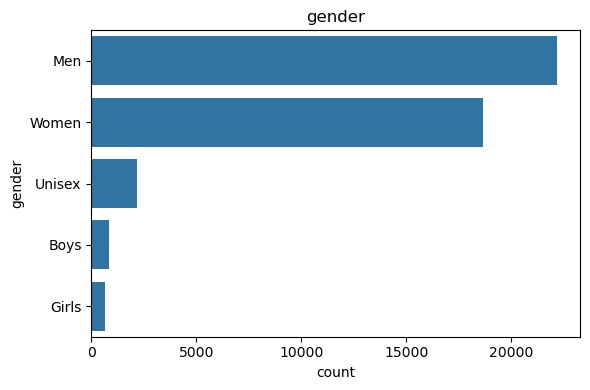

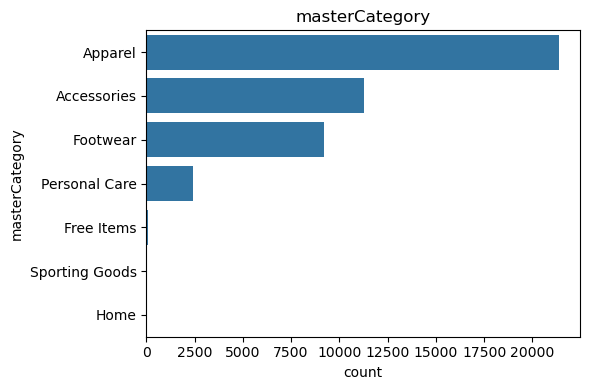

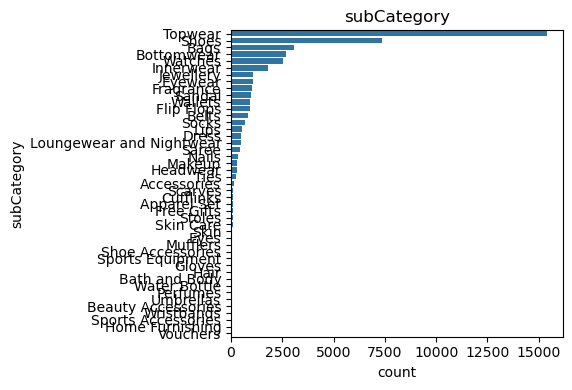

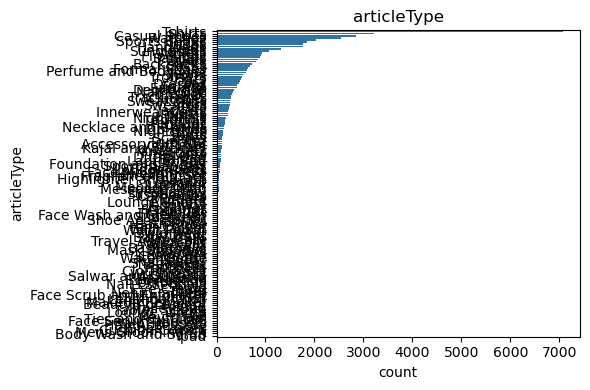

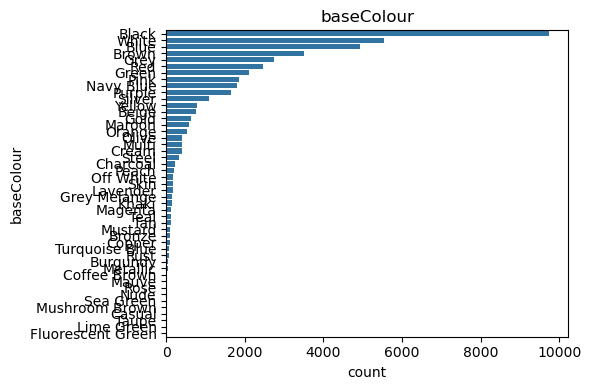

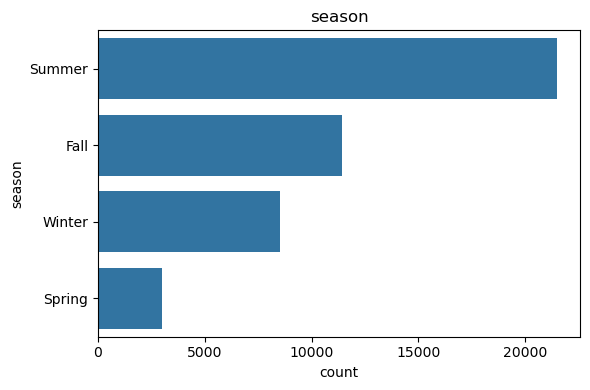

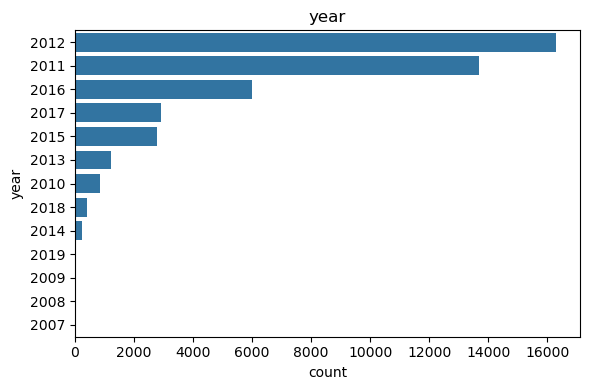

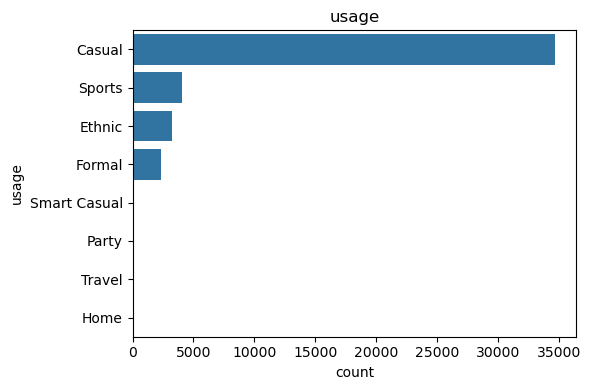

/var/folders/ql/ssl6mf497ls4_dvq3891h2_c0000gn/T/ipykernel_1809/3523337961.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


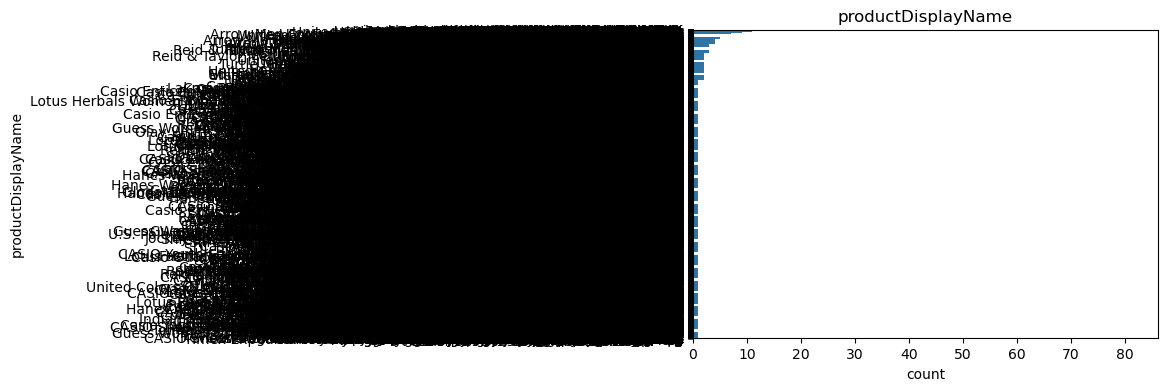

In [326]:
## Deep dive into data, understand the data distribution and relationships

# Split the features into numerical and categorical
numerical_features = ['id', 'year']
categorical_features = ['gender','masterCategory','subCategory','articleType','baseColour','season','year','usage','productDisplayName']

for c in categorical_features:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, y=c, order=df[c].value_counts().index)
    plt.title(c)
    plt.tight_layout()
    plt.show()


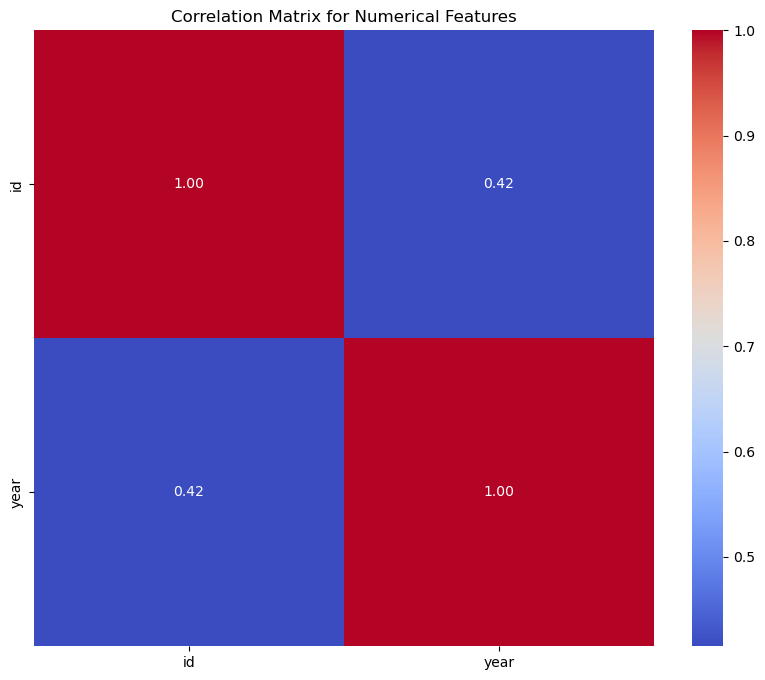

,id,year
id,1.000000,0.415123
year,0.415123,1.000000


In [327]:
# Calculate correlations for numerical features
correlation_matrix = df[numerical_features].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix for Numerical Features")
plt.show()

correlation_matrix

In [330]:
# Display the final set of data after cleaning
print(df.shape),
print(df.info())
print(df.isnull().sum())
print(df.describe())
print(df.describe(include=['object']))
print(df.head())

(44441, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44441 entries, 0 to 44440
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  44441 non-null  int64 
 1   gender              44441 non-null  object
 2   masterCategory      44441 non-null  object
 3   subCategory         44441 non-null  object
 4   articleType         44441 non-null  object
 5   baseColour          44441 non-null  object
 6   season              44441 non-null  object
 7   year                44441 non-null  int64 
 8   usage               44441 non-null  object
 9   productDisplayName  44441 non-null  object
 10  image_path          44441 non-null  object
dtypes: int64(2), object(9)
memory usage: 3.7+ MB
None
id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage   

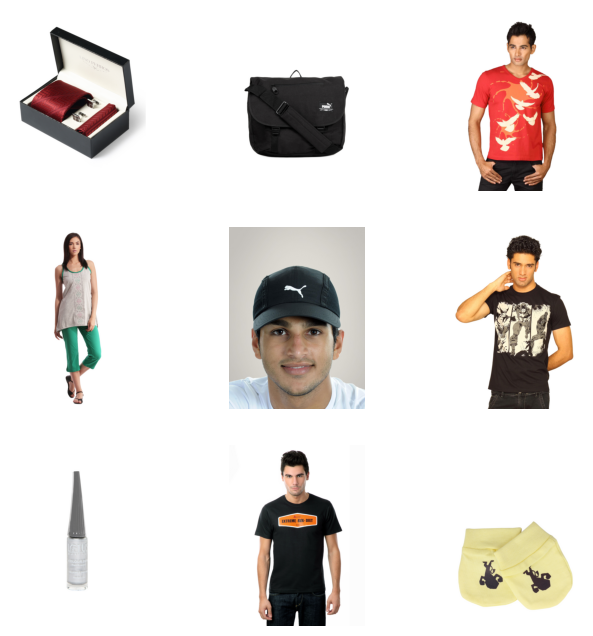

In [332]:
#show some random images from the set

sample = random.sample(df['id'].tolist(), 9)
plt.figure(figsize=(8,8))
for i, pid in enumerate(sample):
    img = Image.open(img_dir/f"{pid}.jpg")
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

### Exploratory Data Analysis (EDA)

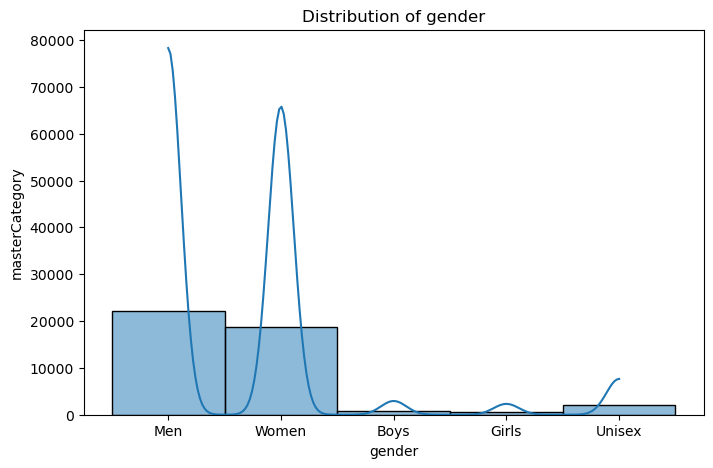

In [334]:
# Distribution of Price
plt.figure(figsize=(8, 5))
sns.histplot(df['gender'], bins=30, kde=True)
plt.title('Distribution of gender')
plt.xlabel('gender')
plt.ylabel('masterCategory')
plt.show()

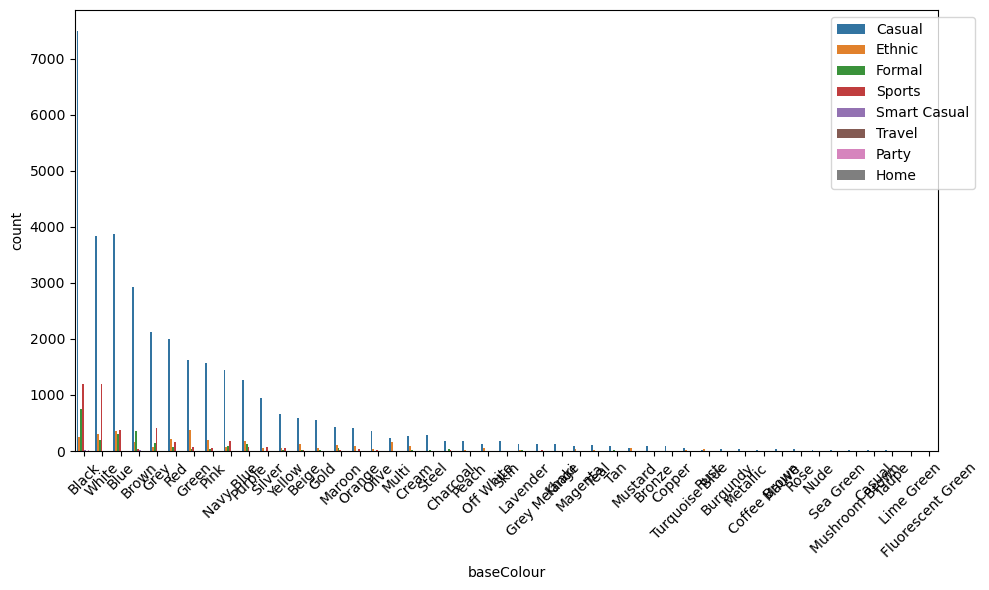

In [336]:
# if baseColour distribution varies by usage
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='baseColour', hue='usage',
              order=df['baseColour'].value_counts().index)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

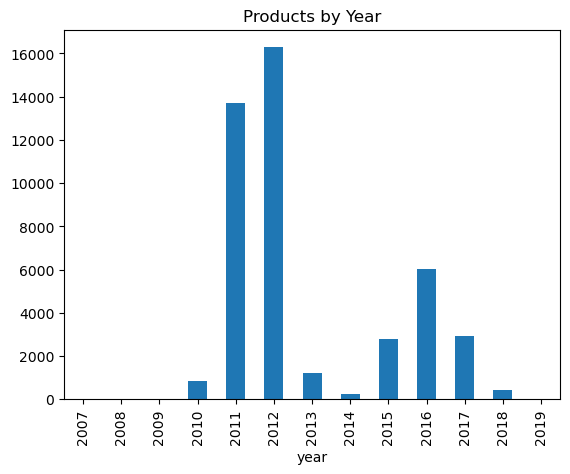

In [338]:
df['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Products by Year')
plt.show()

In [340]:
def img_features(pid):
    img = Image.open(img_dir/f"{pid}.jpg").convert('L')
    arr = np.array(img)
    return pd.Series({'width': img.width, 'height': img.height, 'brightness': arr.mean()})

feat = df['id'].apply(img_features)
df2 = pd.concat([df, feat], axis=1)

### Data Preparation

In [341]:
# Make a copy of the dataset for preprocessing


# Load the provided dataset
file_path = 'fashion-dataset/fashion-dataset/styles.csv'
data = pd.read_csv(file_path, delimiter=';')  # The file appears to use ';' as a delimiter

# Split the features into numerical and categorical
numerical_features = ['id', 'year']
target = 'articleType'
categorical_features = ['gender','masterCategory','subCategory', 'baseColour','season', 'usage','productDisplayName']


features = [col for col in data.columns if col != target]
print('Target Variable: ',target)

# Define categorical and numerical features
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")


# Create a preprocessor using ColumnTransformer
transformers = []
if categorical_features:
   transformers.append(('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features))
if numerical_features:
   transformers.append(('num', StandardScaler(), numerical_features))


# Encode articleType labels
label_encoder = LabelEncoder()
df['article_label'] = label_encoder.fit_transform(df['articleType'])

preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')


# Train-test split
# Splitting the data into training and test sets

X = data[features]
y = data[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the training and test data to CSV files
X_train.to_csv('data/X_train.csv', index=False)
X_test.to_csv('data/X_test.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)

# Display the preprocessed data overview
X_train.shape, X_test.shape

# Preview classes
print(f"Number of unique article types: {len(label_encoder.classes_)}")

Target Variable:  articleType
Numerical features: ['id', 'year']
Categorical features: ['gender', 'masterCategory', 'subCategory', 'baseColour', 'season', 'usage', 'productDisplayName']
Number of unique article types: 142


### Data Modelling

In [344]:
# Load the training and test data from the files created during the last step
# Load the training and test data from the files created during the last step


# File paths
X_train_path = 'data/X_train.csv'
X_test_path = 'data/X_test.csv'
y_train_path = 'data/y_train.csv'
y_test_path = 'data/y_test.csv'

# Load the data
X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Display loaded data shapes
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)


Training features shape: (66276, 9)
Test features shape: (16570, 9)
Training target shape: (66276, 1)
Test target shape: (16570, 1)


### Train Multiple Models + Grid Search + Cross-validation

#### Model 1: Logistic Regression

In [ ]:
param_grid_lr = {
    'C': [0.1, 1, 10]
}

lr = LogisticRegression(max_iter=1000)
grid_lr = GridSearchCV(lr, param_grid_lr, cv=3, scoring='accuracy')

start = time.time()
grid_lr.fit(X_train, y_train)
stop = time.time()

#stats
lr_time = stop - start
lr_params = grid_lr.best_params_
lr_acc = grid_lr.score(X_test, y_test)


print("Best LR Params:", grid_lr.best_params_)
print("CV Accuracy LR:", grid_lr.best_score_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt

Best LR Params: {'C': 10}
CV Accuracy LR: 0.91873377995051


#### Model 2: Random Forest

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy')

start = time.time()
grid_rf.fit(X_train, y_train)
stop = time.time()

#stats
rf_time = stop - start
rf_params = grid_rf.best_params_
rf_acc = grid_rf.score(X_test, y_test)

print("Best RF Params:", grid_rf.best_params_)
print("CV Accuracy RF:", grid_rf.best_score_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs

Best RF Params: {'max_depth': None, 'n_estimators': 100}
CV Accuracy RF: 0.9232753938077133


#### Model 3: Support Vector Machine (SVM)

In [ ]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

svc = SVC()
grid_svc = GridSearchCV(svc, param_grid_svc, cv=3, scoring='accuracy')

start = time.time()
grid_svc.fit(X_train, y_train)
stop = time.time()

#stats
svc_time = stop - start
svc_params = grid_svc.best_params_
svc_acc = grid_svc.score(X_test, y_test)


print("Best SVC Params:", grid_svc.best_params_)
print("CV Accuracy SVC:", grid_svc.best_score_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt

Best SVC Params: {'C': 10, 'kernel': 'rbf'}
CV Accuracy SVC: 0.9192467861669383


In [389]:
# Evaluate Best Model

best_model = grid_rf.best_estimator_  # change to grid_lr or grid_svc if better
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Test Accuracy: 0.9645745322872662


ValueError: Number of classes, 132, does not match size of target_names, 142. Try specifying the labels parameter

In [ ]:
# Model evaluation and summary of results

# Best accuracy: Random Forest with a score of 0.964
# Best recall: Random Forest with a score of 
# Best f1: SVC with a score of 

In [ ]:
#build df 
results_df = pd.DataFrame({'model': ['Logistic Regression', 'Random Forest', 'SVC'], 
              'speed' : [lr_time, rf_time, svc_time],
              'best_params': [lr_params, rf_params, svc_params],
              'accuracy': [lr_acc, rf_acc, svc_acc],
                          }).set_index('model')

In [ ]:
#Make predictions (probabilities for ROC AUC)

y_pred_proba = grid_rf.predict_proba(X_test)[:, 1] 

#Evaluate the model
y_pred = grid_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


#Compute ROC AUC
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
# roc_auc = auc(fpr, tpr)

# print(f'ROC AUC: {roc_auc}')

# #Plot the ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Logistic Regression')
# plt.legend(loc='lower right')
# plt.show()

Accuracy: 0.9645745322872662

Classification Report:
                           precision    recall  f1-score   support

       Accessory Gift Set       1.00      1.00      1.00        36
               Baby Dolls       0.56      0.62      0.59         8
                Backpacks       0.91      0.99      0.95       250
                   Bangle       1.00      1.00      1.00        19
              Basketballs       0.86      1.00      0.92         6
                Bath Robe       0.83      0.71      0.77         7
         Beauty Accessory       1.00      1.00      1.00         3
                    Belts       1.00      1.00      1.00       297
                  Blazers       1.00      0.33      0.50         3
              Body Lotion       1.00      1.00      1.00         5
                  Booties       1.00      1.00      1.00         4
                   Boxers       1.00      0.84      0.91        19
                      Bra       0.93      0.96      0.95       191
        

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


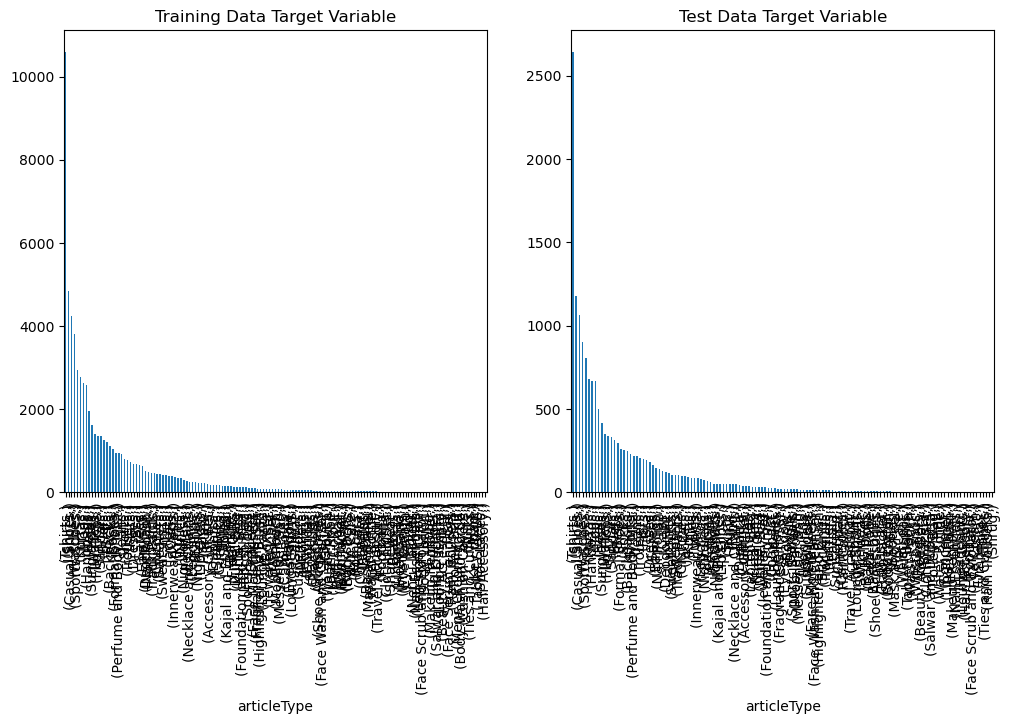

In [419]:
# plot the bar chart of the target variable in test and training data

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
y_train.value_counts().plot(kind='bar', ax=ax[0], title='Training Data Target Variable')
y_test.value_counts().plot(kind='bar', ax=ax[1], title='Test Data Target Variable')
plt.show()

### Image → Title (Caption Generator), Category(Classifier)

#### Step 1

In [ ]:
# Image generator
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = datagen.flow_from_dataframe(
    df,
    directory="images",
    x_col="image_path",
    y_col="articleType",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    subset="training"
)

val_gen = datagen.flow_from_dataframe(
    df,
    directory="images",
    x_col="image_path",
    y_col="articleType",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    subset="validation"
)

# Load pre-trained ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add classification head
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile and train
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_gen, validation_data=val_gen, epochs=5)  # Increase epochs for better results


Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 44441 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 44441 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

#### Step 2

In [407]:
# Get image features
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

def extract_feature(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = feature_extractor.predict(x)
    return features.flatten()

# Extract features for a subset of images
df_subset = df.sample(1000, random_state=42)  # Reduce size for example
img_dir = Path('fashion-dataset/fashion-dataset/images')
df_subset['features'] = df_subset['image_path'].apply(lambda x: extract_feature(os.path.join(img_dir, x)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

### Auto Generate Title and Category for a sample image

In [408]:
# Recommend product title/category for a new image
test_img_dir = Path('fashion-dataset/fashion-dataset/test_images')
query_img = os.path.join(test_img_dir, '1.png')
query_feat = extract_feature(query_img)

similarities = cosine_similarity([query_feat], list(df_subset['features']))
top_idx = np.argmax(similarities)
recommended_title = df_subset.iloc[top_idx]['productDisplayName']
recommended_cat = df_subset.iloc[top_idx]['articleType']
print("Recommended Title:", recommended_title)
print("Recommended Category:", recommended_cat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Recommended Title: Status Quo Men Solid Navy Blue Tshirts
Recommended Category: Tshirts
